![banner](../img/cdips_2017_logo.png)

# Support Vector Regression

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as skl
import numpy as np

import seaborn as sns
sns.set(font_scale=2)

import scripts.load_data as load

%matplotlib inline

In [11]:
import sklearn.decomposition
import sklearn.svm
from sklearn.model_selection import train_test_split

### Support Vector Methods

[Support Vector Machines](https://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/)
are a powerful, widely-used technique for classifying data.
[Support Vector Regression](https://alex.smola.org/papers/2003/SmoSch03b.pdf)
is an extension of the more popular support vector machine classifier
to regression problems.

The key tools used by support vector methods are *support vectors* and *kernels*.

#### Kernels

The *kernel function* takes two data points and computes a measure of their similarity.
For example, the dot product of two vectors is a linear kernel function.
Another example of a kernel function is the
*squared exponential* kernel,
also known as the *Gaussian* kernel
or the *radial basis function*.
Mathematically, it looks like this:

$$
k(x,x') = \exp\left(-\frac{(x-x')^2}{2l}\right)
$$

Plotted out, the similarity to a Gaussian is clear:

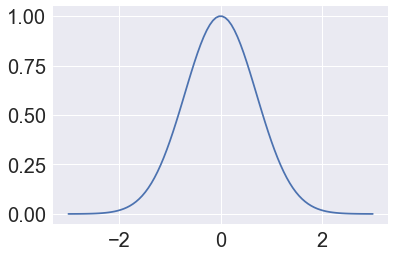

In [12]:
xs = np.linspace(-3,3,100)
plt.plot(xs,np.exp(-1*np.square(xs)));

#### Support Vectors

The *support vectors* are a subset of the training set.

To calculate the prediction of a support vector method for an input,
we take the input and compute the result of the kernel function
applied to the input and each of the support vectors.

Let's call our test input
$\mathbf{x^*}$,
our support vectors $\mathbf{SV_i}$,
and the outputs of the kernel function
$z_i$.

We calculate those outputs using this equation:

$$
    z_i = k(\mathbf{SV_i},\mathbf{x^*})
$$

We then treat this $\mathbf{z}$ as the inputs to a
[linear model](03 - Linear Regression.ipynb).
That is, we calculate the actual output of our support vector machine,
$\hat{y}$
by taking a weighted sum of these $z$s and adding a bias term:

$$
\begin{align}
\hat{y} &= \sum_i w_i z_i + b \\
        &= \mathbf{w}^T\mathbf{z} + b
\end{align}
$$

The choice of support vectors and weights is made, as always,
by optimizing an objective function over the training data.
The details of this optimization procedure are
[extremely interesting](http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf)
and use some very cool math,
but they aren't important here.

#### Support Vector Regression and Multiple Outputs

However, due to the details of how optimization is performed in support vector regression,
there is not a simple, trivial extension
to the case where there are multiple outputs to predict --
where $\hat{y}$ is a vector, as in our data.

The simplest way around this issue
is to train multiple models,
with each one predicting one dimension of our output:
one model for calcium content,
one model for pH,
and so on.
Then, when we want to predict all five outputs for a new data point,
we combine the predictions of all five models into a single output
by just concatenating them.

In [13]:
def trainSVR(SVR_models, X_train, y_train):
    for output_idx, SVR_model in enumerate(SVR_models):
        SVR_model.fit(X_train, y_train.iloc[:, output_idx])

def scoreSVR(SVR_models,X_test,y_test):
    
    score = np.zeros(len(SVR_models))
    y_pred = np.zeros(y_test.shape)
    
    for output_idx,SVR_model in enumerate(SVR_models):
        y = y_test.iloc[:,output_idx]
        y_hat = SVR_model.predict(X_test)
        y_pred[:,output_idx] = y_hat
    
    score = sklearn.metrics.r2_score(y_test, y_pred, multioutput='variance_weighted')
    
    return score

In [14]:
def PCA_transform(X_train, X_test):
    PCA = sklearn.decomposition.PCA(n_components=100).fit(X_train)
    
    X_train = PCA.transform(X_train)
    X_test = PCA.transform(X_test)
    
    return X_train, X_test, PCA

In [15]:
def makePlot(schedule,train_scores,test_scores):
    
    mean_train_scores = np.mean(train_scores,axis=0)
    mean_test_scores = np.mean(test_scores,axis=0)

    sd_train_scores = np.std(train_scores,axis=0,ddof=1)
    sd_test_scores = np.std(test_scores,axis=0,ddof=1)
    
    plt.figure(figsize=(12,4))
    ax = plt.subplot(111)
    ax.set_xscale("log", nonposx='clip')
    
    plt.errorbar(schedule,mean_train_scores,
                 yerr=sd_train_scores,
             linewidth=4,alpha=0.75,
             label='Train')
    
    plt.errorbar(schedule,mean_test_scores,
                 yerr=sd_test_scores,
             linewidth=4,alpha=0.75,
             label='Test')
    
    plt.ylim([0,1]);

    plt.xlabel("Hyperparameter Value");
    plt.ylabel(r'$R^2$')
    plt.legend();
    
def getBest(test_scores,to_keep_schedule):
    
    mean_test_scores = np.mean(test_scores,axis=0)
    
    best_score_index = np.argmax(mean_test_scores)
    best_score = mean_test_scores[best_score_index]
    best_score_num_dimensions = to_keep_schedule[best_score_index]
    print("the best value of the HP is: "+ str(best_score_num_dimensions))

In [16]:
X,y = load.load_training_spectra();

## Best Model

As with most successful machine learning methods,
support vector methods have
hyperparameters that must be tuned with
[cross-validation](01 - Cross Validation Primer.ipynb).
Because training an ensemble of five support vector regression models
takes much longer than training any of our other models,
we use a special from of cross-validation,
called *greedy cross-validation*,
as described in the section below.

This process still takes a good amount of time
\- up to an hour on a laptop.
If you'd just like to train up the best model
so you can inspect it,
simply run the cells below.

In [17]:
C=100; epsilon=1e-1; gamma=5e-3 #selected, in that order, by greedy cross-validation

In [18]:
num_outputs = y.shape[1]

SVR_models = [sklearn.svm.SVR(kernel='rbf',
                            C=C, epsilon=epsilon, gamma=gamma) for _ in range(num_outputs)]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)

X_train, X_test, PCA = PCA_transform(X_train, X_test)

In [20]:
trainSVR(SVR_models, X_train, y_train)

In [21]:
scoreSVR(SVR_models,X_test,y_test)

0.69947330698776522

## Comparing SVR and Linear Regression with Cross-Validation

In [22]:
num_splits = 20

SVR_train_scores = np.zeros(num_splits)
SVR_test_scores = np.zeros(num_splits)

C=100; epsilon=1e-1; gamma=1e-2 #selected, in that order, by greedy cross-validation
SVR_models = [sklearn.svm.SVR(kernel='rbf',
                            C=C, epsilon=epsilon, gamma=gamma) for _ in range(num_outputs)]

for split_idx in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
    X_train, X_test, PCA = PCA_transform(X_train, X_test)
    
    trainSVR(SVR_models, X_train, y_train)
    SVR_train_scores[split_idx] = scoreSVR(SVR_models,X_train,y_train)
    SVR_test_scores[split_idx] = scoreSVR(SVR_models,X_test,y_test)

In [23]:
linear_model = sklearn.linear_model.LinearRegression()

num_splits = 20

linear_train_scores = np.zeros(num_splits)
linear_test_scores = np.zeros(num_splits)

for split_idx in range(num_splits):
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
    X_train, X_test, PCA = PCA_transform(X_train, X_test)
    
    linear_model.fit(X_train, y_train)
    linear_train_scores[split_idx] = linear_model.score(X_train,y_train)
    linear_test_scores[split_idx] = linear_model.score(X_test,y_test)

In [24]:
def display_crossvalidated_results(model_name, train_scores, test_scores):
    
    plt.errorbar([0,1], [np.mean(train_scores), np.mean(test_scores)],
                      yerr=[np.std(train_scores,ddof=1), np.std(test_scores, ddof=1)],
                 linewidth=4,
                label = model_name)
    plt.xlim([-0.5, 1.5])
    plt.ylim([0,1])
    plt.ylabel(r'$R^2$')
    plt.xticks([0, 1], ['Train', 'Test'])
    plt.legend(loc='best')

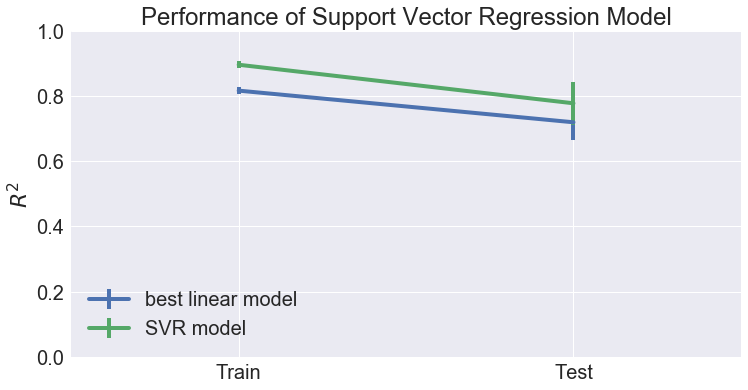

In [25]:
plt.figure(figsize=(12,6))
display_crossvalidated_results('best linear model', linear_train_scores, linear_test_scores)
display_crossvalidated_results('SVR model', SVR_train_scores, SVR_test_scores)
plt.title("Performance of Support Vector Regression Model");

Somewhat surprisingly,
the performance gain for using
a support vector regression model
over a
[linear model]()
is minimal.

This is also true for
[neural networks](04_A - Neural Network Regression.ipynb).
The results from the
[Kaggle leaderboard](https://www.kaggle.com/c/afsis-soil-properties/leaderboard),
though not directly comparable,
seem to indicate that the ceiling for
performance on this dataset is
not far above the performance
of a linear model.

## Greedy Cross-Validation

Because support vector methods take a long time to train, we chose to run *greedy* cross-validation. That is, we used cross-validation to optimize one hyperparameter, holding the others fixed, then fixed the value of that hyperparameter and moved on to the next one.

There are three major hyperparameters:
- `epsilon` - errors smaller than `epsilon` don't contribute to the cost function. Higher values discourage over-fitting, but may cause under-fitting.
- `C` - determines how intensely to punish errors larger than `epsilon`. Higher values give more complex decision functions, at the cost of potential over-fitting.
- `gamma` - inversely determines the width of the basis function. With smaller values, the data points selected as support vectors will influence predictions further and further away, resulting in smoother predictions that might under-fit.

The below cells check `C` across six orders of magnitude.

In [17]:
C_schedule = np.logspace(-2,3,6)
num_splits = 20

train_scores = np.zeros((num_splits,len(C_schedule)))
test_scores = np.zeros_like(train_scores)

for C_idx,C in enumerate(C_schedule):
    SVR_models = [sklearn.svm.SVR(C=C) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        X_train, X_test, PCA = PCA_transform(X_train, X_test)
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,C_idx] = scoreSVR(SVR_models,X_train,y_train)
        test_scores[split_idx,C_idx] = scoreSVR(SVR_models,X_test,y_test)

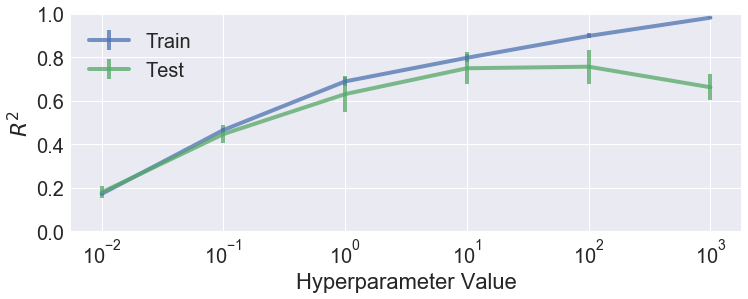

In [18]:
makePlot(C_schedule,train_scores,test_scores)

From the chart above,
it appears that score on the test set is reaching a plateau,
even as the training score keeps going up.
This is a classic sign of
[overfitting](01 - Cross Validation Primer.ipynb).

One piece of advice given for fitting models
is to first ensure that you can over-fit your data,
then adjust hyperparameters and pre-processing to combat over-fitting.

In that spirit,
we select `C=1000`.

The next cell tests `epsilon` across four orders of magnitude, with `C` set to the value determined above.
The default value of `epsilon` caused very high training and test error,
so we aimed for smaller values of `epsilon`.

In [19]:
eps_schedule = np.logspace(-2,0,6)
num_splits = 20

train_scores = np.zeros((num_splits,len(eps_schedule)))
test_scores = np.zeros_like(train_scores)

for eps_idx,eps in enumerate(eps_schedule):
    SVR_models = [sklearn.svm.SVR(epsilon=eps,C=1000.) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        X_train, X_test, PCA = PCA_transform(X_train, X_test)
        
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,eps_idx] = scoreSVR(SVR_models,X_train,y_train)
        test_scores[split_idx,eps_idx] = scoreSVR(SVR_models,X_test,y_test)

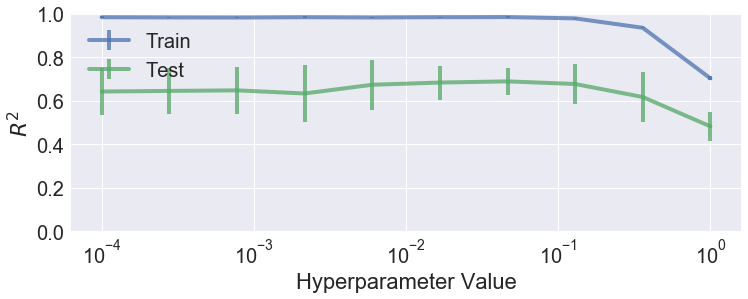

In [20]:
makePlot(eps_schedule,train_scores,test_scores)

Interestingly, varying `epsilon` appeared to have no effect.
We stuck with the default value of $10^{-1}$.

The last parameter to tune was `gamma`. The default value is 1/`n_features`, or $10^{-2}$.
Our current issue is over-fitting,
so we primarily examine values lower than the default,
which result in smoother solutions.

In [21]:
num_splits = 20

gamma_schedule = np.logspace(-4,-1,10)

train_scores = np.zeros((num_splits,len(gamma_schedule)))
test_scores = np.zeros_like(train_scores)

for gamma_idx,gamma in enumerate(gamma_schedule):
    SVR_models = [sklearn.svm.SVR(epsilon=1e-1, C=1000., gamma=gamma) for _ in range(num_outputs)]
    for split_idx in range(num_splits):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,)
        X_train, X_test, PCA = PCA_transform(X_train, X_test)
        
        trainSVR(SVR_models,X_train,y_train)
        train_scores[split_idx,gamma_idx] = scoreSVR(SVR_models,X_train,y_train)
        test_scores[split_idx,gamma_idx] = scoreSVR(SVR_models,X_test,y_test)

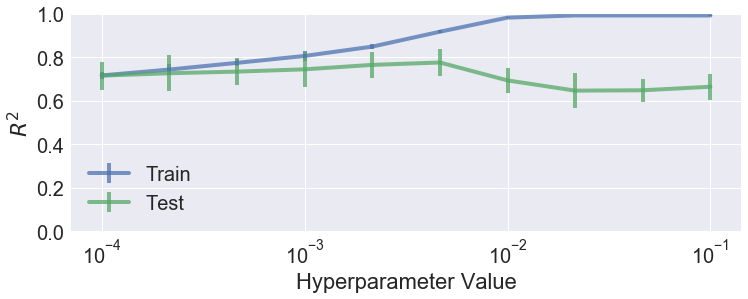

In [22]:
makePlot(gamma_schedule,train_scores,test_scores)

Though adjusting `gamma` has only a modest effect on test set performance,
making it smaller gets rid of our over-fitting issue.
We select the value that has
highest test set score,
which is roughly
`0.005`.